# Parallelism for Image Pre-processing

In [18]:
import numpy as np
import tensorflow as tf
import pickle
import cv2
import os
import matplotlib.pyplot as plt
import time

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from numpy import asarray, save
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array



## Read image into ndarray

In [19]:
# Set default image size
default_image_size = tuple((256, 256))

image_size = 0
directory_root = '../Data'
width=256
height=256
depth=3 

In [20]:
# function to convert images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size) 
          #  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [21]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)


    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        copy=listdir(f"{directory_root}/{plant_folder}")
        plant_list = []
        print(plant_disease_folder_list)
        for disease_folder in copy :
            # remove .DS_Store from list
            print(disease_folder)
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
            
                
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:150]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")


[INFO] Loading images ...
['Tomato_healthy', 'Potato___Early_blight', 'PlantVillage', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Early_blight', '.DS_Store', 'Tomato__Target_Spot', 'Potato___Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus', 'Pepper__bell___Bacterial_spot', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Pepper__bell___healthy', 'Potato___healthy']
Tomato_healthy
Potato___Early_blight
PlantVillage
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Early_blight
.DS_Store
Tomato__Target_Spot
Potato___Late_blight
Tomato_Leaf_Mold
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Septoria_leaf_spot
Tomato__Tomato_mosaic_virus
Pepper__bell___Bacterial_spot
Tomato_Bacterial_spot
Tomato_Late_blight
Pepper__bell___healthy
Potato___healthy
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing PlantVillage ...
[INFO] Processing Tomato__Tomato_Yel

In [22]:
#Binarize 
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
#pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

# Check number of classes
print(n_classes)

15


In [23]:
image_list = np.array(image_list, dtype=np.float32)

In [24]:
#Define the function to plot image from ndarray.
def show_image(x):
    plt.imshow(np.clip(x, 0, 1))

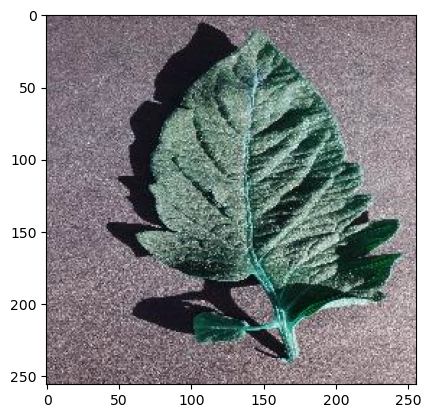

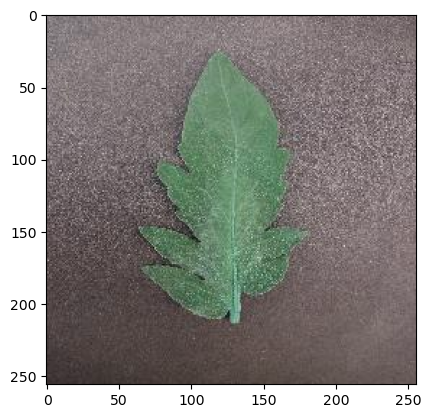

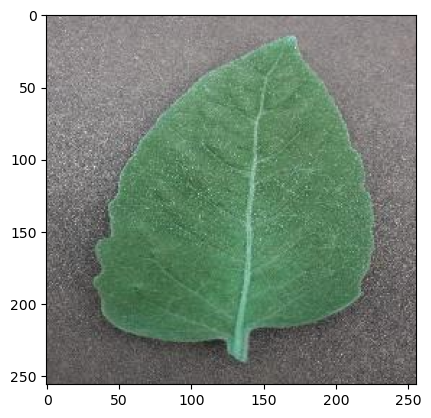

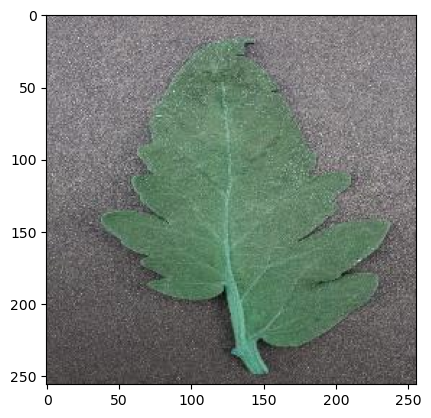

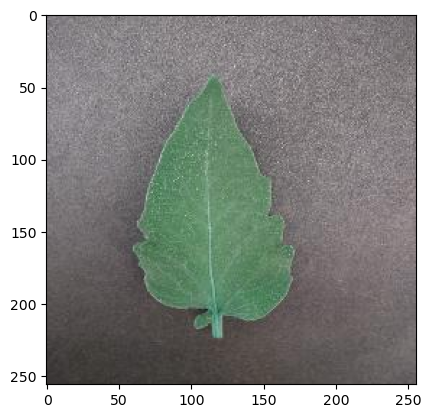

In [25]:
#plot first five images from image list
for i in range(5):
    plt.show(show_image(image_list[i]/255))


## Crop Image from all sides via edge detection

https://stackoverflow.com/questions/33998364/crop-image-from-all-sides-after-edge-detection

We've noticed that some of the images in our dataset contain a lot of background, which may not be relevant to our analysis. To address this issue, we can use edge detection to automatically crop the images. We're exploring this option as a way to illustrate the use of multi-processing capabilities. However, it's important to note that after cropping, the resulting images may have different sizes, which could be not ideal for model training.

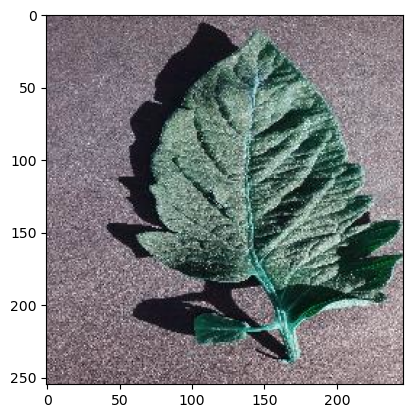

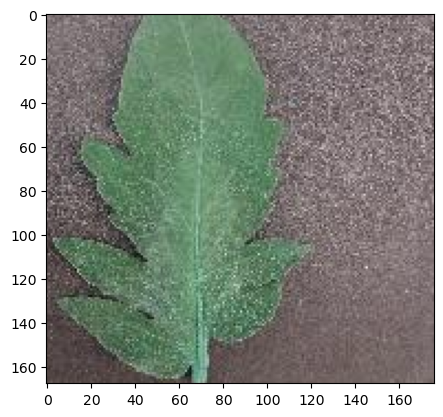

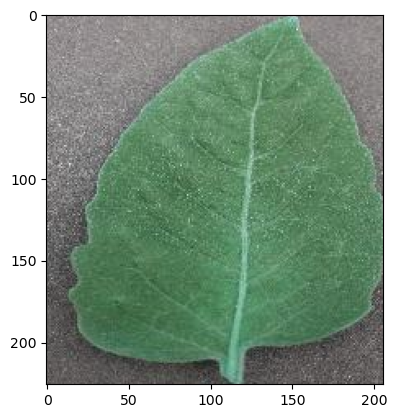

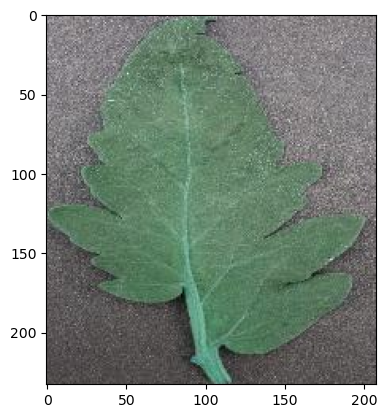

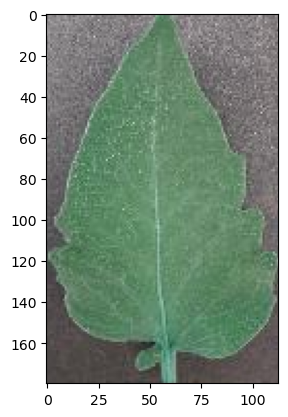

In [26]:
for i in range(5):
    img = image_list[i].astype(np.uint8)
    blurred = cv2.blur(img, (3,3))
    canny = cv2.Canny(blurred, 50, 200)

    ## find the non-zero min-max coords of canny
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)

    ## crop the region
    cropped = img[y1:y2, x1:x2]
    plt.show(show_image(cropped/255))

## Multi-processing

https://stackoverflow.com/questions/62759940/parallelization-strategies-for-deep-learning

In [27]:
import multiprocessing
from multiprocessing import Pool

In [28]:
start_time = time.time()
for i in range(len(image_list)):
    img = image_list[i].astype(np.uint8)
    blurred = cv2.blur(img, (3,3))
    canny = cv2.Canny(blurred, 50, 200)

    ## find the non-zero min-max coords of canny
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)

    ## crop the region
    cropped = img[y1:y2, x1:x2]/255
print("Time taken to auto-crop images: " + str(time.time() - start_time))

Time taken to auto-crop images: 2.567805051803589


In [51]:
def auto_crop(image_list):
    for i in range(len(image_list)):
        img = image_list[i].astype(np.uint8)
        blurred = cv2.blur(img, (3,3))
        canny = cv2.Canny(blurred, 50, 200)

         ## find the non-zero min-max coords of canny
        pts = np.argwhere(canny>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)

        ## crop the region
        cropped = img[y1:y2, x1:x2]/255
    return cropped

In [30]:
cpu_count = multiprocessing.cpu_count()
print(cpu_count)

8


In [44]:
def separate_data(data,split_n):
    split_data = []
    split_length = int(len(data) / split_n)
    for i in range(split_n):
        if i == (split_n - 1):
            new_data = data[i*split_length:]
        new_data = data[i*split_length: (i+1)*split_length]
        split_data.append (new_data)
    return split_data

In [45]:
def concat_data(split_data):
    output = [ ]
    for i in range (len(split_data)):
        output += split_data[i]
    return output

In [46]:
def process_pool (function, split_n, *args) :
    pool = multiprocessing.Pool (processes= split_n)
    for i in range(split_n):
        pool. apply_async (function,(i, *args))
    pool.close()
    pool.join()
    print ("Sub-process(es) done.")
    pass

In [54]:
if __name__ == "__main__":
    data = image_list
    split_n = 4
    split_data = separate_data(data,split_n)
    process_pool(auto_crop, split_n, split_data)
    concat = concat_data(split_data)

Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'auto_crop' on <module '__main__' (built-in)>
Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py",

KeyboardInterrupt: 

Process SpawnPoolWorker-21:
Traceback (most recent call last):
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: invalid load key, '\xc6'.
Process SpawnPoolWorker-22:
Traceback (most recent call last):
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/xin/opt/anaconda3/envs/sklearn-env/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._tar